In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Note on this data and analysis

### I have not yet found an authorititative GIS file with flood depths, which would be necessary to filter out blocks that did not sustain significant flooding. As a result, this analysis includes all blocks/neighborhoods in New Orleans.

### When looking for examples I have been excluding areas that are known not to have sustained major flood damage. As a result, some of the examples chosen may appear odd when compared with full lists since there are neighborhoods that will appear to have been skipped. Such neighborhoods include, but are no means limited to, Old and New Aurora, Tall Timbers and Behrman (all of which are on the West Bank and did not flood), Audubon and Uptown (which are in areas that sustained only minor flooding). 

### I do have access to one dataset that appears to match the flood levels we have reported previously, though I cannot fully track its provenance. I will continue working on this so that we can have a more objective way of filtering out areas that we plan to exclude.

## Preparing data

In [2]:
# Road Home Data provided by Louisiana Division of Administration. 
# Aggregated to Census Blocks (2000)
rh = pd.read_csv('raw data/PRR 8_22_22.csv')

# 2000 Census Block boundary files.
blocks = gpd.read_file('shapefiles/blocks/tl_2010_22_tabblock00.shp')
blocks = blocks.to_crs('epsg:3452')

# Converting blocks to centroids for join with neighborhoods
blocks_centroids = blocks.copy()
blocks_centroids['geometry'] = blocks_centroids['geometry'].centroid

flood_blocks = gpd.read_file('shapefiles/flood_blocks/flood_blocks.shp')

# Neighborhood data provided by the city of New Orleans. 
# Note that the neighborhood boundaries are based on Census Tract Boundaries. This file is based on the 2010 Tracts. 
# Currently checking with the Data Center (which generates the boundaries) about whether there were changes between 
# the 2000 and 2010 vintage boundaries. If so, I've requested a copy of the 2000 vintage. Boundary changes are typically 
# very minor, but may have some impact on the overall analysis.
neighborhoods = gpd.read_file('shapefiles/neighborhoods/Neighborhood_Statistical_Areas.shp')
neighborhoods = neighborhoods.to_crs('epsg:3452')

# Get neighborhood for each block
blocks_neighborhoods = gpd.sjoin(blocks_centroids, neighborhoods[['GNOCDC_LAB', 'geometry']])

In [3]:
# P004 from Census 2000 Summary File 1: Hispanic or Latino and Not Hispanic of Latino by Race by Block
blocks_race = pd.read_csv('raw data/2000-La-HispanicRaceByBlock.csv', skiprows=[0])

# Rename relevant columns for easy reference
blocks_race = blocks_race.rename(
    columns = {
        'Total!!Hispanic or Latino' : 'Hispanic',
        'Total!!Not Hispanic or Latino!!Population of one race!!White alone' : 'White',
        'Total!!Not Hispanic or Latino!!Population of one race!!Black or African American alone' : 'Black',
        'Total!!Not Hispanic or Latino!!Population of one race!!American Indian and Alaska Native alone' : 'Indigenous',
        'Total!!Not Hispanic or Latino!!Population of one race!!Asian alone' : 'Asian',
        'Total!!Not Hispanic or Latino!!Population of one race!!Native Hawaiian and Other Pacific Islander alone' : 'NHOPI',
        'Total!!Not Hispanic or Latino!!Population of one race!!Some other race alone' : 'Other',
        'Total!!Not Hispanic or Latino!!Population of two or more races' : 'Multiracial'
    })
blocks_race = blocks_race[['Total', 'White', 'Black', 'Hispanic', 'Indigenous', 'Asian', 'NHOPI', 'Other', 'Multiracial', 'Geography']]


In [4]:
# Get GEOID from each df
blocks_race['GEOID'] = blocks_race['Geography'].apply(lambda x: x.split('US')[1])
rh['GEOID'] = rh['Census Block'].astype(str)
blocks_neighborhoods['GEOID'] = blocks_neighborhoods['BLKIDFP00']
blocks['GEOID'] = blocks['BLKIDFP00']

In [5]:
# Combine datasets. 
# NOTE: This is an outer join that will include blocks with no RH grants
rh_blocks = (
    blocks
        .merge(rh, on = 'GEOID', how = 'outer')
        .merge(blocks_neighborhoods[['GNOCDC_LAB', 'GEOID']], on = 'GEOID', how = 'outer')
        .merge(blocks_race[['Total', 'White', 'Black', 'Hispanic', 'Indigenous', 'Asian', 'NHOPI', 'Other', 'Multiracial', 'GEOID']], on = 'GEOID', how = 'outer')
    )

In [6]:
# Field descriptions
# compensation_sum: Sum of compensation grants
# additional_compensation_sum: Sum of additional compensation grants
# elevation_sum: Sum of elevation grants
# mitigation_sum: Sum of mitigation grants
# all_grants_sum: Sum of compensation, additional compensation, elevation and mitigation grants
# all_grounts_count: Count of properties that received grants
# value_sum: Sum of pre-storm value of properties
# damage_sum: Sum of damage asessment
# insurance_sum: Sum of gross insurance payments


rh_blocks = rh_blocks.rename(
    columns = {
        'GNOCDC_LAB' : 'Neighborhood',
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }
)


In [7]:
neighborhood_fields = [
    'Neighborhood',
    'compensation_sum',
    'additional_compensation_sum',
    'elevation_sum', 
    'mitigation_sum', 
    'all_grants_sum', 
    'all_grants_count',
    'value_sum', 
    'damage_sum', 
    'insurance_sum',
    'Total', 
    'White', 
    'Black', 
    'Hispanic', 
    'Indigenous', 
    'Asian', 
    'NHOPI',
    'Other', 
    'Multiracial'
]

rh_neighborhoods = rh_blocks[neighborhood_fields].groupby('Neighborhood').sum()
# Merge with geometry
rh_neighborhoods = neighborhoods[['GNOCDC_LAB','geometry']].set_index('GNOCDC_LAB').merge(rh_neighborhoods, left_index=True, right_index=True)


In [8]:
# Function to generate useful fields for various geographies
#
# Field descriptions
# grant_insurance_sum: Sum of payments from Compensation Grants, Additional Compensation Grants and Insurance
# grant_insurance_mean: Mean payment per property
# uncovered_sum: Sum of damage assessments not covered by grants or insurance
# uncovered_mean: Mean amount not covered per property
# uncovered_percent: Percent of damage not covered

def helper_fields(df):
    df['damage_mean'] = df['damage_sum'] / df['all_grants_count']
    df['grant_insurance_sum'] = df['compensation_sum']+df['additional_compensation_sum']+df['insurance_sum']
    df['grant_insurance_mean'] = df['grant_insurance_sum']/df['all_grants_count']
    df['uncovered_sum'] = df['damage_sum'] - df['grant_insurance_sum']
    df['uncovered_mean'] = df['uncovered_sum']/df['all_grants_count']
    df['uncovered_percent'] = (df['damage_sum']-df['grant_insurance_sum'])/df['damage_sum']
    df['white_percent'] = df['White']/df['Total']
    return df

In [9]:
rh_blocks = helper_fields(rh_blocks)
rh_neighborhoods = helper_fields(rh_neighborhoods)

# Create dataframe of just New Orleans blocks
rh_blocks_nola = rh_blocks[rh_blocks['COUNTYFP00']=='071']

## Basic data exploration and visualization

### Maps

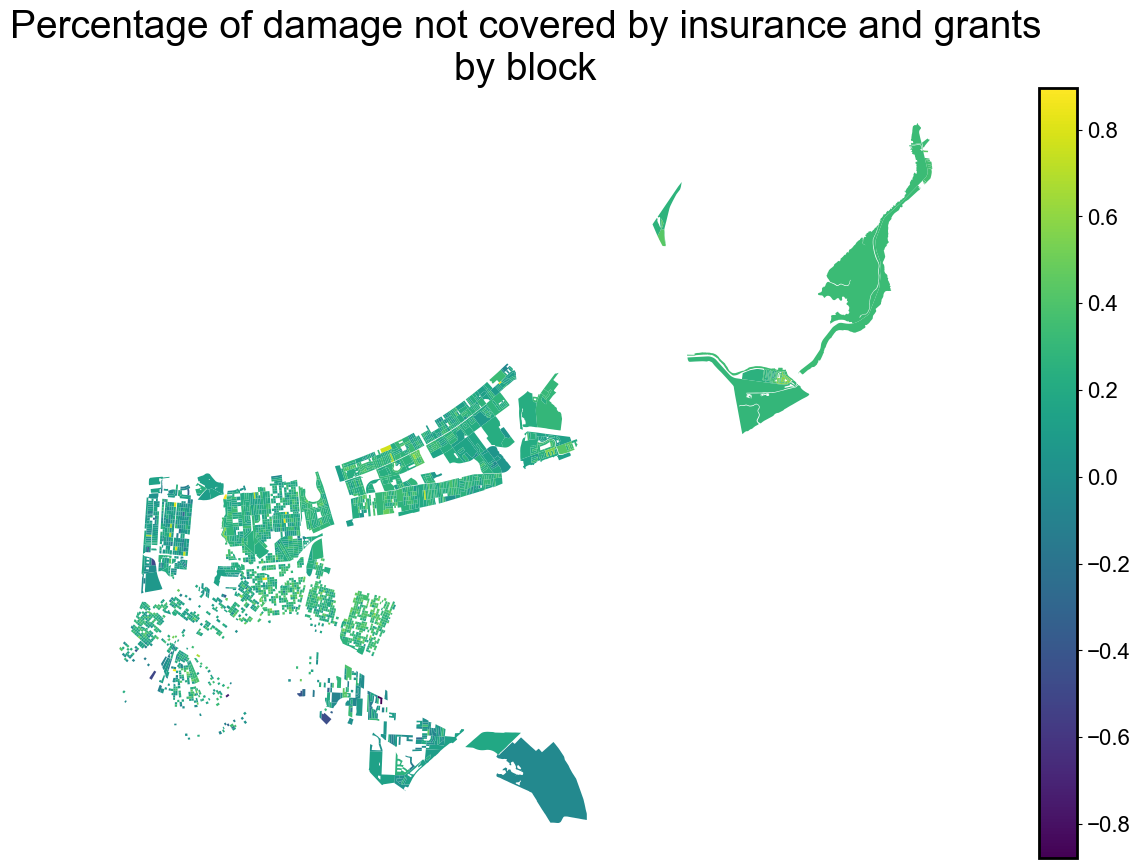

In [10]:
fig, ax = plt.subplots(figsize=(17,10))
rh_blocks_nola.plot(column='uncovered_percent', ax=ax, legend=True)
plt.title('Percentage of damage not covered by insurance and grants\nby block')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

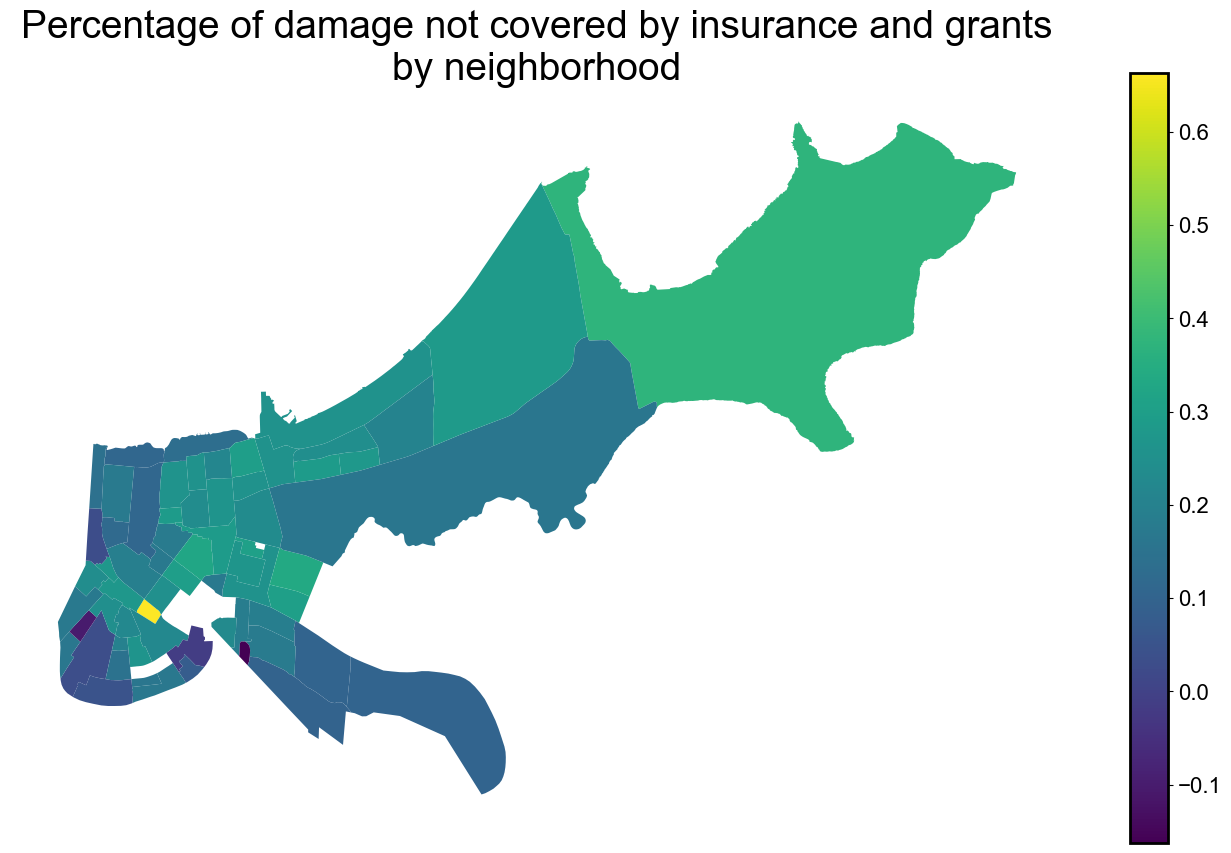

In [11]:
fig, ax = plt.subplots(figsize=(17,10))
rh_neighborhoods.plot(column='uncovered_percent', ax=ax, legend=True)
plt.title('Percentage of damage not covered by insurance and grants\nby neighborhood')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

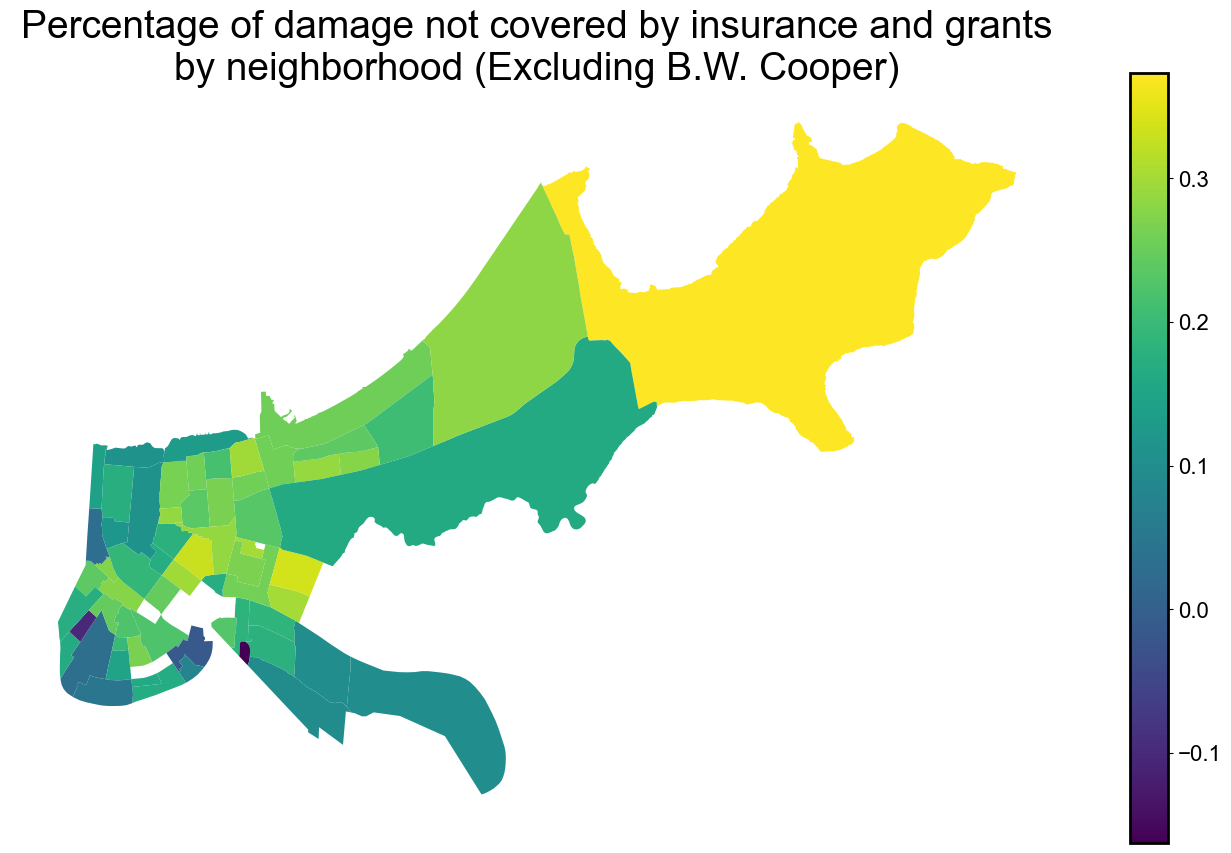

In [12]:
# Exclude B.W. Cooper, which is an outlier, to enhance contrast between other neighborhoods

fig, ax = plt.subplots(figsize=(17,10))
rh_neighborhoods[rh_neighborhoods.index !='B. W. COOPER'].plot(column='uncovered_percent', ax=ax, legend=True)
plt.title('Percentage of damage not covered by insurance and grants\nby neighborhood (Excluding B.W. Cooper)')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

### Percent of uncovered damage by blocks and neighborhoods

There is at least a slight relationship between the percentage of damage not covered by grants or insurance and the percentage of a blocks population that is not White.

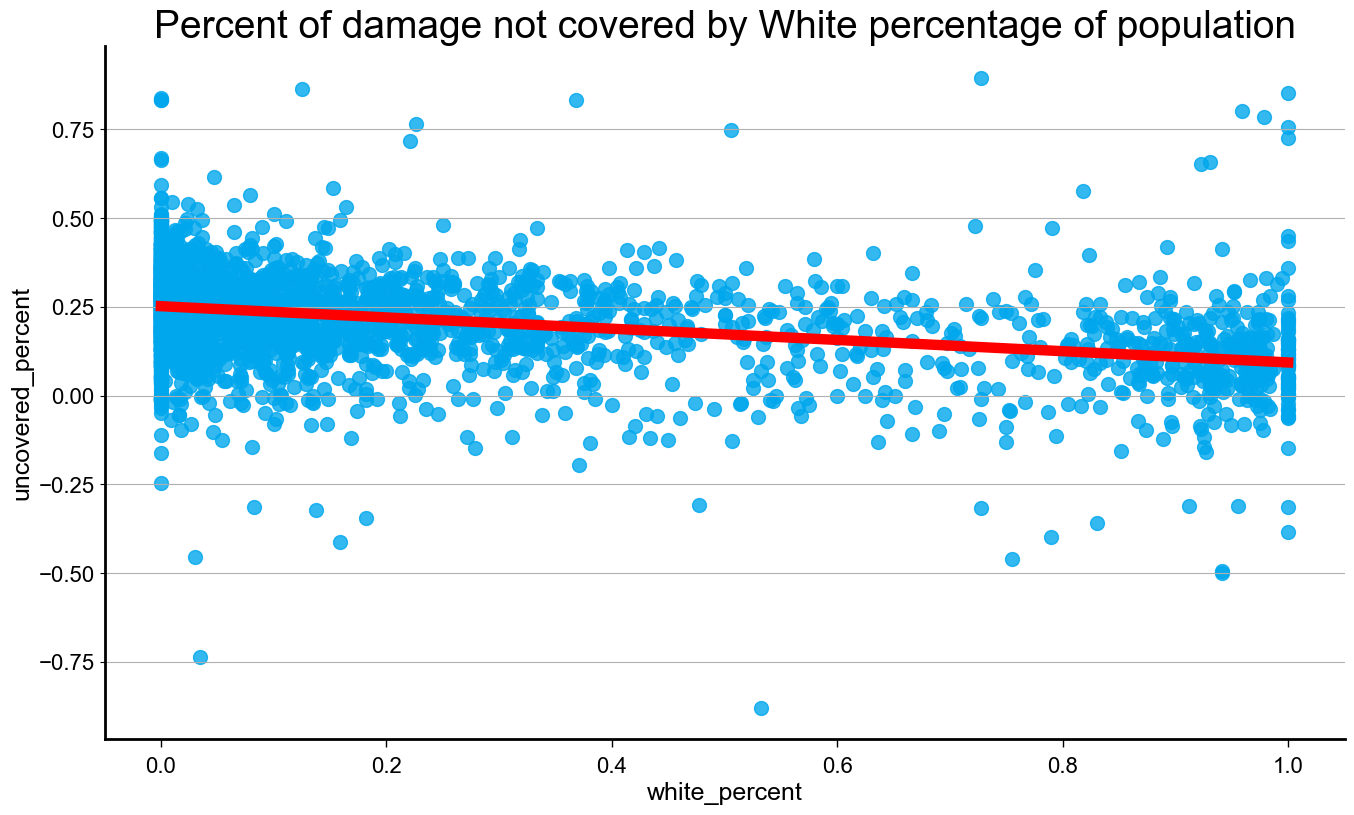

In [17]:
fig, ax = plt.subplots()
sns.regplot(rh_blocks_nola, x='white_percent', y='uncovered_percent', line_kws={'color' : 'red'}, ax=ax)
plt.title('Percent of damage not covered by White percentage of population')
plt.show()
plt.close()

A similar relationship appears at the neighborhood level

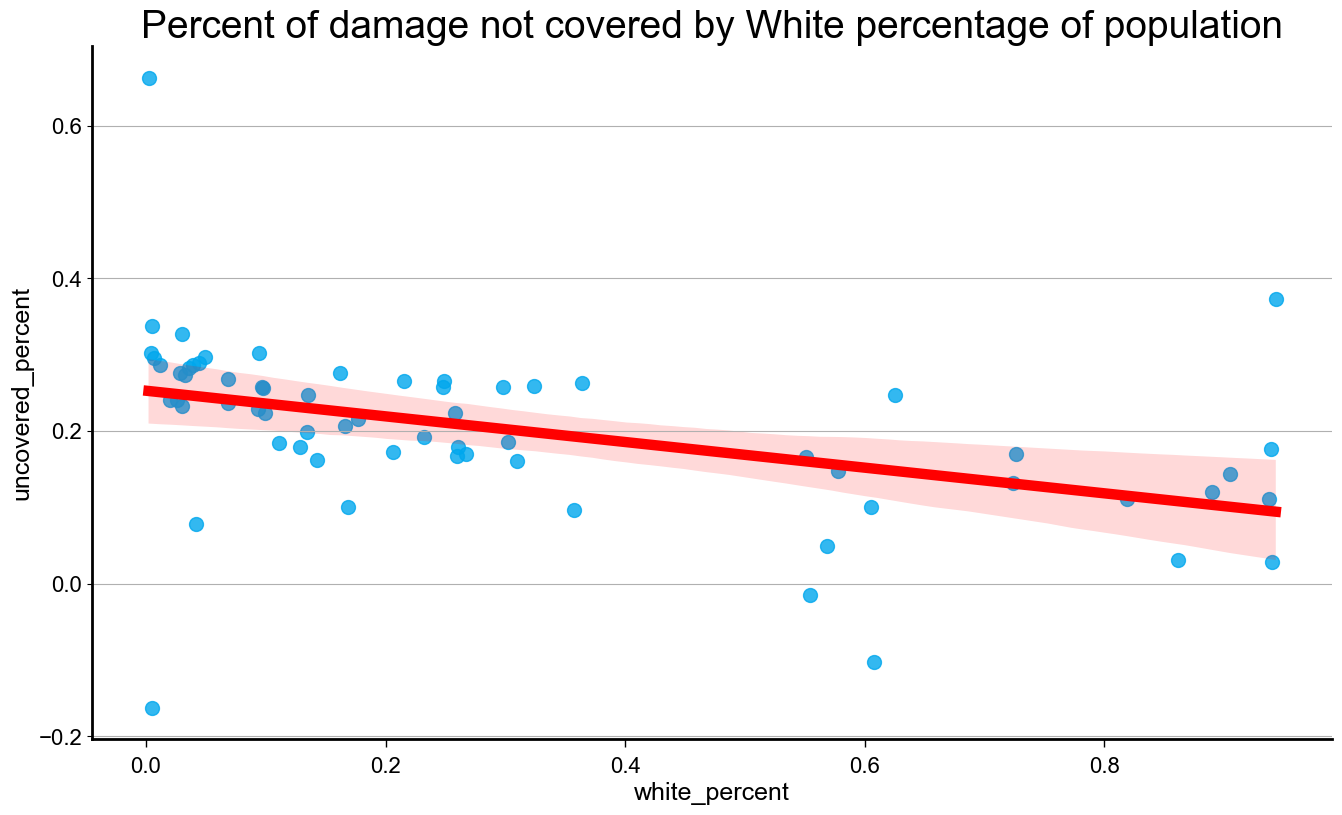

In [19]:
fig, ax = plt.subplots()
sns.regplot(rh_neighborhoods, x='white_percent', y='uncovered_percent', line_kws={'color' : 'red'}, ax=ax)
plt.title('Percent of damage not covered by White percentage of population')
plt.show()
plt.close()

## Damage and compensation by neighborhood

In [25]:
(
    rh_neighborhoods[rh_neighborhoods['damage_sum']>0][
        [
            'damage_sum', 
            'grant_insurance_sum', 
            'grant_insurance_mean', 
            'uncovered_sum', 
            'uncovered_mean', 
            'uncovered_percent', 
            'white_percent'
    ]
]
.sort_values(by='uncovered_percent')
)

,damage_sum,grant_insurance_sum,grant_insurance_mean,uncovered_sum,uncovered_mean,uncovered_percent,white_percent
FISCHER DEV,"482,237.20","560,594.14","70,074.27","-78,356.94","-9,794.62",-0.16,0.00
EAST CARROLLTON,"902,028.54","994,622.71","62,163.92","-92,594.17","-5,787.14",-0.10,0.61
LOWER GARDEN DISTRICT,"201,319.67","204,443.63","29,206.23","-3,123.96",-446.28,-0.02,0.55
LAKEWOOD,"61,986,403.38","60,247,832.30","289,653.04","1,738,571.08","8,358.51",0.03,0.94
AUDUBON,"12,321,741.75","11,933,777.78","172,953.30","387,963.97","5,622.67",0.03,0.86
WEST RIVERSIDE,"362,086.76","344,474.98","26,498.08","17,611.78","1,354.75",0.05,0.57
ST. THOMAS DEV,"1,675,964.03","1,544,500.04","81,289.48","131,463.99","6,919.16",0.08,0.04
TALL TIMBERS - BRECHTEL,"16,570,327.61","14,981,925.20","53,316.46","1,588,402.41","5,652.68",0.10,0.36
OLD AURORA,"20,941,113.09","18,846,906.26","47,473.32","2,094,206.83","5,275.08",0.10,0.60
NEW AURORA - ENGLISH TURN,"24,402,140.91","21,956,434.12","49,119.54","2,445,706.79","5,471.38",0.10,0.17


## Additional Compensation Grants

The additional compensation grants did have an impact, particularly in neighborhoods with large amounts of damage that was not covered. But even with those grants, there were still large amounts of damage that went uncovered

In [40]:
wo_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0][['compensation_sum', 'insurance_sum', 'damage_sum', 'all_grants_count']].apply(lambda x: (x['damage_sum'] - (x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1).sort_values(ascending=False)
w_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0]['uncovered_percent']

acg_compare = pd.concat([wo_acg.rename('Without ACG'), w_acg.rename('With ACG')], axis=1)
acg_compare['Difference'] = acg_compare['Without ACG'] - acg_compare['With ACG']
acg_compare.sort_values(by="Difference")

,Without ACG,With ACG,Difference
LOWER GARDEN DISTRICT,-0.02,-0.02,0.00
LAKEWOOD,0.03,0.03,0.00
AUDUBON,0.04,0.03,0.01
LAKESHORE - LAKE VISTA,0.12,0.11,0.01
LAKEVIEW,0.19,0.18,0.01
LAKE TERRACE & OAKS,0.14,0.13,0.01
CITY PARK,0.13,0.11,0.02
WEST RIVERSIDE,0.07,0.05,0.02
NAVARRE,0.14,0.12,0.02
WEST END,0.16,0.14,0.02


## Amount uncovered by property by neighborhood

<span class="tex2jax_ignore">The limits on compensation could mean tens of thousands of dollars of uncovered costs for homeowners in primarily non-White neighborhoods that were hard-hit by the storm. For example, even with ACG Lower Ninth Ward homeowners who received grants could expect to be more than &dollar;66,000 short of their damage assessment. In the Seventh Ward, the discrepency was about &dollar;64,000 and in Pontchartrain Park it was about &dollar;63,000.

<span class="tex2jax_ignore">On the other end of the scale, Lakewood residents could expect to be about &dollar;8,000 out of pocket and City Park residents were about &dollar;16,000 short.

<span class="tex2jax_ignore">Looked at another way:
<span class="tex2jax_ignore">In Lakewood, the average amount not covered by insurance and grants was 5% of the mean household income (&dollar;153,990 in 2000 dollars) or about two and a half week's pay.
<span class="tex2jax_ignore">In the Seventh Ward it was nearly 2.5 years' salary (mean household income &dollar;26,519 in 2000 dollars).</span>

In [56]:
rh_neighborhoods[['uncovered_mean', 'white_percent']].sort_values(by='uncovered_mean', ascending=False)

,uncovered_mean,white_percent
B. W. COOPER,"179,910.67",0.00
LAKE CATHERINE,"109,805.46",0.94
FILMORE,"68,946.64",0.36
LOWER NINTH WARD,"66,365.97",0.00
SEVENTH WARD,"63,773.73",0.03
PONTCHARTRAIN PARK,"62,526.87",0.01
PLUM ORCHARD,"60,463.82",0.04
HOLY CROSS,"60,336.81",0.09
READ BLVD WEST,"59,282.17",0.16
FLORIDA AREA,"58,382.67",0.00


## Options for comparisons

There's a few options for comparisons, depending on how we want to approach this.

On the extremes, a comparison of Lakewood to the Lower Ninth or Seventh Ward (as mentioned above) would show a dramatic contrast. This would pershaps be heightened by the fact that Lakewood suffered far more flooding than the Seventh Ward and yet recovered far better.

I think there's a reasonable comparison to be made between Pontchartrain Park (a middle-class Black neighborhood) and Navarre (a middle class White neighborhood). Alternatively, Pontchartrain Park could be compared to West End, a slightly higher-class White neighborhood but which had a similar number of damaged properties to Pontchartrain Park. 

I think there's also some value to including some of the New Orleans East neighborhoods, though this may become tricky both because of their size (some have an order of magnitude more claims than the Lakeview neighborhoods) and because their income tends to be significantly lower than the other examples I mentioned. West Lake Forest or Plum Orchard at least are areas with similar counts to other neighborhoods, so those might be a good place to start.



In [57]:
rh_neighborhoods[['all_grants_count', 'damage_mean', 'uncovered_percent', 'white_percent']].sort_values(by='damage_mean')

,all_grants_count,damage_mean,uncovered_percent,white_percent
WEST RIVERSIDE,13.00,"27,852.83",0.05,0.57
LOWER GARDEN DISTRICT,7.00,"28,759.95",-0.02,0.55
U.S. NAVAL BASE,92.00,"46,003.11",0.19,0.30
OLD AURORA,397.00,"52,748.40",0.10,0.60
NEW AURORA - ENGLISH TURN,447.00,"54,590.92",0.10,0.17
EAST CARROLLTON,16.00,"56,376.78",-0.10,0.61
WHITNEY,47.00,"56,579.73",0.18,0.11
BEHRMAN,397.00,"58,163.68",0.18,0.13
TALL TIMBERS - BRECHTEL,281.00,"58,969.14",0.10,0.36
FISCHER DEV,8.00,"60,279.65",-0.16,0.00


## Further research and/or analysis:
- Exclude areas with minimal flooding (still looking for authoritative flooding GIS data)
- More in-depth and valid regression analysis
- Research potentially needed on B.W. Cooper and Lake Catherine
- Research needed on neighborhoods/blocks that received more in grants and insurance than their damage assessments (could this be explained by insurance that paid the actual replacement value, which may have been more than RH's formula?)

In [13]:
rh_blocks.to_csv('processed data/rh_blocks.csv')

In [ ]:
rh_neighborhoods.to_csv('processed data/rh_neighborhoods.csv')